<a href="https://colab.research.google.com/github/Yospy/MixUp-Image-Augmentation/blob/main/MixUp_Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from numpy import *
import matplotlib.pyplot as plt

In [2]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train = X_train.astype("float32")/255.0
X_train = reshape(X_train, (-1,28,28,1))
y_train = tf.one_hot(y_train,10)

X_test = X_test.astype("float32") / 255.0
X_test = reshape(X_test, (-1,28,28,1))
y_test = tf.one_hot(y_test,10)

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
Auto = tf.data.AUTOTUNE
batch = 64
epochs = 10

In [4]:
val = 2000
X_val,y_val = X_train[:val],y_train[:val]
nx_train,ny_train = X_train[val:],y_train[val:]

train_done = (
    tf.data.Dataset.from_tensor_slices((nx_train,ny_train))
    .shuffle(batch*100)
    .batch(batch)

)

train_dtwo = (
    tf.data.Dataset.from_tensor_slices((nx_train,ny_train))
    .shuffle(batch*100)
    .batch(batch)
)

train_ds = tf.data.Dataset.zip((train_done,train_dtwo))

val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(batch)

test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(batch)

In [5]:
def samplebeta(size,conc_0=0.2,conc_1=0.2):
  gamma_1s = tf.random.gamma(shape=[size],alpha=conc_1)
  gamma_2s = tf.random.gamma(shape=[size],alpha=conc_0)
  return gamma_1s / (gamma_1s+gamma_2s)


def mix_up(ds_one,ds_two, alpha=0.2):
  images_one, label_one = ds_one
  images_two, label_two = ds_two
  batch_size = tf.shape(images_one)[0]

  l = samplebeta(batch_size,alpha,alpha)
  x_l = tf.reshape(l, (batch_size,1,1,1))
  y_l = tf.reshape(l, (batch_size,1))

  images = images_one * x_l + images_two * (1 - x_l)
  labels = label_one * y_l + label_two * (1 - y_l)
  return images, labels




[0.0, 0.0016602873802185059, 0.0, 0.0, 0.9983397126197815, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.9353302717208862, 0.0, 0.0, 0.0, 0.0, 0.06466972827911377, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0003642579249572009, 0.0, 0.0, 0.9996357560157776, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.7285346984863281e-06, 0.0, 0.0, 0.9999982714653015, 0.0, 0.0, 0.0]
[0.06541614979505539, 0.934583842754364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.7308171987533569, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2691827714443207]
[0.0, 0.04898696392774582, 0.0, 0.0, 0.0, 0.0, 0.9510130286216736, 0.0, 0.0, 0.0]
[0.0, 0.9091072678565979, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0908927321434021]


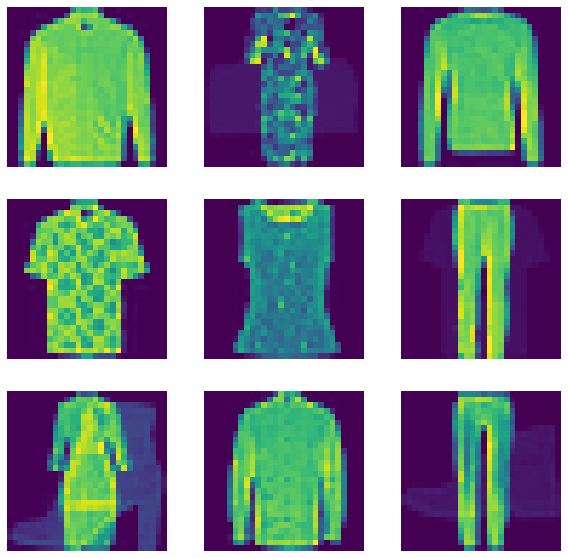

In [6]:

train_ds_mu = train_ds.map(lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=Auto)


sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10,10))
for i, (image,label) in enumerate(zip(sample_images[:9],sample_labels[:9])):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image.numpy().squeeze())
  print(label.numpy().tolist())
  plt.axis("off")

In [7]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(64,(5,5),activation='relu',input_shape=(28,28,1)),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Conv2D(128,(5,5),activation='relu'),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.GlobalAvgPool2D(),
                             tf.keras.layers.Dense(128,activation='sigmoid'),
                             tf.keras.layers.Dense(10,activation='sigmoid')                          
])

In [8]:
model.compile(loss='categorical_crossentropy',metrics=['acc'],optimizer='adam')
model.fit(train_ds_mu,validation_data=val_ds,epochs=epochs)

Epoch 1/10
907/907 [==============================] - 175s 191ms/step - loss: 1.1425 - acc: 0.6465 - val_loss: 0.6628 - val_acc: 0.7570
Epoch 2/10
907/907 [==============================] - 157s 173ms/step - loss: 0.8868 - acc: 0.7473 - val_loss: 0.5199 - val_acc: 0.8255
Epoch 3/10
907/907 [==============================] - 157s 173ms/step - loss: 0.7949 - acc: 0.7906 - val_loss: 0.4444 - val_acc: 0.8510
Epoch 4/10
907/907 [==============================] - 156s 172ms/step - loss: 0.7478 - acc: 0.8104 - val_loss: 0.4132 - val_acc: 0.8620
Epoch 5/10
907/907 [==============================] - 160s 176ms/step - loss: 0.7097 - acc: 0.8225 - val_loss: 0.3736 - val_acc: 0.8725
Epoch 6/10
907/907 [==============================] - 161s 177ms/step - loss: 0.6832 - acc: 0.8358 - val_loss: 0.3712 - val_acc: 0.8680
Epoch 7/10
907/907 [==============================] - 161s 178ms/step - loss: 0.6637 - acc: 0.8387 - val_loss: 0.3559 - val_acc: 0.8780
Epoch 8/10
907/907 [============================

In [9]:
import pandas as pd
df = pd.DataFrame(model.history.history)
df

,loss,acc,val_loss,val_acc
0,1.142487,0.646500,0.662821,0.7570
1,0.886796,0.747293,0.519882,0.8255
2,0.794875,0.790621,0.444436,0.8510
3,0.747823,0.810397,0.413157,0.8620
4,0.709693,0.822466,0.373583,0.8725
5,0.683201,0.835776,0.371223,0.8680
6,0.663740,0.838690,0.355861,0.8780
7,0.649260,0.843379,0.329277,0.8865
8,0.639191,0.846776,0.327791,0.8785
9,0.629884,0.847983,0.327589,0.8850


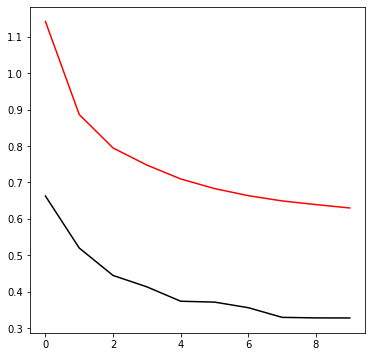

In [10]:
plt.figure(figsize=(6,6))
loss = df.loss
vloss = df['val_loss']
plt.plot(loss,color='r')
plt.plot(vloss,color='black')

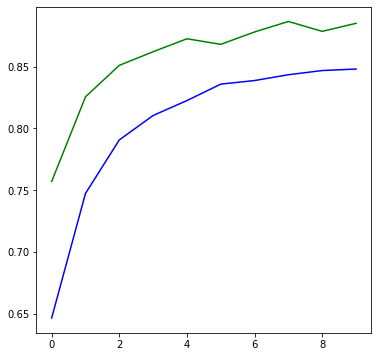

In [11]:
plt.figure(figsize=(6,6))
acc = df.acc
vacc = df['val_acc']
plt.plot(acc,color='blue')
plt.plot(vacc,color='g')

Training without mixed up dataset

In [12]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
model.fit(train_done,validation_data=val_ds,epochs=epochs)

Epoch 1/10
907/907 [==============================] - 172s 189ms/step - loss: 0.3037 - acc: 0.8893 - val_loss: 0.2944 - val_acc: 0.8875
Epoch 2/10
907/907 [==============================] - 195s 215ms/step - loss: 0.2878 - acc: 0.8952 - val_loss: 0.2835 - val_acc: 0.8975
Epoch 3/10
907/907 [==============================] - 182s 200ms/step - loss: 0.2723 - acc: 0.9003 - val_loss: 0.2614 - val_acc: 0.9015
Epoch 4/10
907/907 [==============================] - 166s 183ms/step - loss: 0.2624 - acc: 0.9040 - val_loss: 0.2608 - val_acc: 0.9015
Epoch 5/10
907/907 [==============================] - 167s 184ms/step - loss: 0.2565 - acc: 0.9061 - val_loss: 0.2579 - val_acc: 0.9010
Epoch 6/10
907/907 [==============================] - 218s 240ms/step - loss: 0.2461 - acc: 0.9091 - val_loss: 0.2506 - val_acc: 0.9025
Epoch 7/10
907/907 [==============================] - 179s 197ms/step - loss: 0.2395 - acc: 0.9131 - val_loss: 0.2823 - val_acc: 0.8955
Epoch 8/10
907/907 [============================